In [2]:
# Test cell 

In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [3]:
t1 = time.time()

channels = constants.channel_list
for data_type in ['Wake']:   
    

    print(data_type)
    
    
    
    paths , class_list, sleep_night_list , sleep_type_list , participant_id_list = constants.generate_paths_and_info(blue_pebble = True)
    
    selected_paths , s_class_list , s_night_list , s_sleep_type , s_p_id = [], [], [], [], []

    for path , class_name, night , p_id in zip(paths, class_list, sleep_night_list, participant_id_list ):
        if data_type in path:
            selected_paths.append(path) 
            s_class_list.append(class_name)
            s_night_list.append(night)
            s_sleep_type.append(data_type)
            s_p_id.append(p_id)

    #2. Load corresponding data into dataframes , store in dataframe list
    df_list = []
    error_paths = []
    with io.capture_output() as captured:
        for path in selected_paths:
            try:
                data_epo = mne.read_epochs(path)
                data = data_epo._data * 1e6  # convert signal from V to uV
                df_full = data_epo.to_data_frame()
                df = df_full[channels].copy()
                df_list.append(df)
            except:
                error_paths.append(path)
    
    #Remove paths with errors from lists 
    for path in error_paths:
        path_index = selected_paths.index(path)
        #pop that index from all lists
        selected_paths.pop(path_index) 
        s_class_list.pop(path_index)
        s_night_list.pop(path_index)
        s_sleep_type.pop(path_index)
        s_p_id.pop(path_index)

t2 = time.time()

t2-t1

Wake


8.17318320274353

In [9]:
t1 = time.time()

ts_row_list = []

for df in df_list:
    #1.Generate the window indices 
    window_indices = eeg_stat_ts.gen_window_indices(6, df , samp_freq = 256)
    #2. Calculate max freq stats per window
    max_freqs__per_win_df = eeg_stat_ts.gen_statistic_per_window(df , window_indices , stat = 'normalised_psd')
    #3. Convert bpw per window per channel into bpw per window per region
    regional_df = eeg_stat_ts.convert_chan_stats_to_region(max_freqs__per_win_df, constants.channel_list , constants.region_to_channel_dict, average_type = 'mean')
    # #4. Convert into a single row of a new dataframe where each cell is a series
    new_row = eeg_stat_ts.dataframe_to_ts_row(regional_df, list(regional_df.columns[:-1]) )
    ts_row_list.append(new_row)
    
ts_df = pd.DataFrame.from_records(ts_row_list)

t2 = time.time()

t2-t1

39.22413444519043

In [12]:
# Save everything in the appropriate place ---->  final_transformed_df, groups , y
folder = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Gen_New_Features/generated_feats/'
ts_df.to_hdf(folder + data_type + 'six_second_psd_normalised_df.h5' , key = 'df', mode = 'w')

/tmp/ipykernel_236901/127773004.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['1.25_Central', '1.5_Central', '1.75_Central', '2.0_Central',
       '2.25_Central', '2.5_Central', '2.75_Central', '3.0_Central',
       '3.25_Central', '3.5_Central',
       ...
       '125.75_Right Temporal', '126.0_Right Temporal',
       '126.25_Right Temporal', '126.5_Right Temporal',
       '126.75_Right Temporal', '127.0_Right Temporal',
       '127.25_Right Temporal', '127.5_Right Temporal',
       '127.75_Right Temporal', '128.0_Right Temporal'],
      dtype='object', length=6604)]

  ts_df.to_hdf(folder + data_type + 'six_second_psd_normalised_df.h5' , key = 'df', mode = 'w')


#### Load the data and use it

In [53]:
X = pd.read_hdf(folder + 'Wake' + 'six_second_psd_normalised_df.h5' , key='df', mode='r')
y = pd.read_hdf(load_path + '_y.h5', key='df', mode='r') 
groups = pd.read_hdf(load_path + '_groups.h5', key='df', mode='r')  

# Replace time sereis data with mean of the data ______________________________________________________________________________________________________

# Defining a function to replace time series of values with their mean
def function(x):
    return x.values.mean()
    
#Construct the static features
static_features_df = X.apply(np.vectorize(function))
X = static_features_df.copy()
X_1 = X[[col for col in X.columns if 'Prefrontal' in col]]
X_2 = X[[col for col in X.columns if 'Left Temporal' in col]]

In [60]:
X_1_sub = X_1.iloc[:, :100]
X_2_sub = X_2.iloc[:, :100]

#3. Use all of the features
all_data_dict = {'All_regions' : list(X_1_sub.columns) + list(X_2_sub.columns), 'All_regions_2' :  list(X_1_sub.columns) + list(X_2_sub.columns)}

In [58]:
X_relevant_freqs = X.iloc[: , :100]

#3. Use all of the features
all_data_dict = {'All_regions' : list(X_relevant_freqs.columns) , 'All_regions_2' : list(X_relevant_freqs.columns)}

In [61]:
#1.Generate expt specific X,y,groups
t1 = time.time()

X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(pd.concat([X_1_sub , X_2_sub] , axis = 1),y,groups, 2 )
results_df = run_expts.run_mv_tsc(X_expt,y_expt,groups_expt, {'RF' : RandomForestClassifier(random_state = 5) , 'DT' : DecisionTreeClassifier() , 'Ada_B' : AdaBoostClassifier(random_state = 5)} , return_df = True , subset_names_and_cols = all_data_dict, random_states = [1,2] )
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)

sub_df_1 = pd.DataFrame(res_df[[col for col in res_df.columns if 'acc' in col and 'RF' in col]].mean(axis = 0)).T.rename(columns=lambda x: x.replace('RF_', ''))
sub_df_2 = pd.DataFrame(res_df[[col for col in res_df.columns if 'acc' in col and 'DT' in col]].mean(axis = 0)).T.rename(columns=lambda x: x.replace('DT_', ''))
sub_df_3 = pd.DataFrame(res_df[[col for col in res_df.columns if 'acc' in col and 'Ada_B' in col]].mean(axis = 0)).T.rename(columns=lambda x: x.replace('Ada_B_', ''))

df = pd.concat([sub_df_1, sub_df_2, sub_df_3])
df.insert(0, 'clf',  ['RF', 'DT', 'Ada_B'])
df.insert(1, 'Max_acc',  df.iloc[:,1:].max(axis = 1).values)

display(df)


t2 = time.time()
time_taken = t2-t1
print(time_taken)

,clf,Max_acc,All_regions_acc,All_regions_2_acc
0,RF,0.630357,0.630357,0.630357
0,DT,0.555357,0.555357,0.514286
0,Ada_B,0.567857,0.567857,0.567857


4.009210586547852


In [66]:
freqs = np.arange(1.25, 128.25, 0.25)

In [88]:
import matplotlib.patches as mpatches

<Figure size 640x480 with 0 Axes>

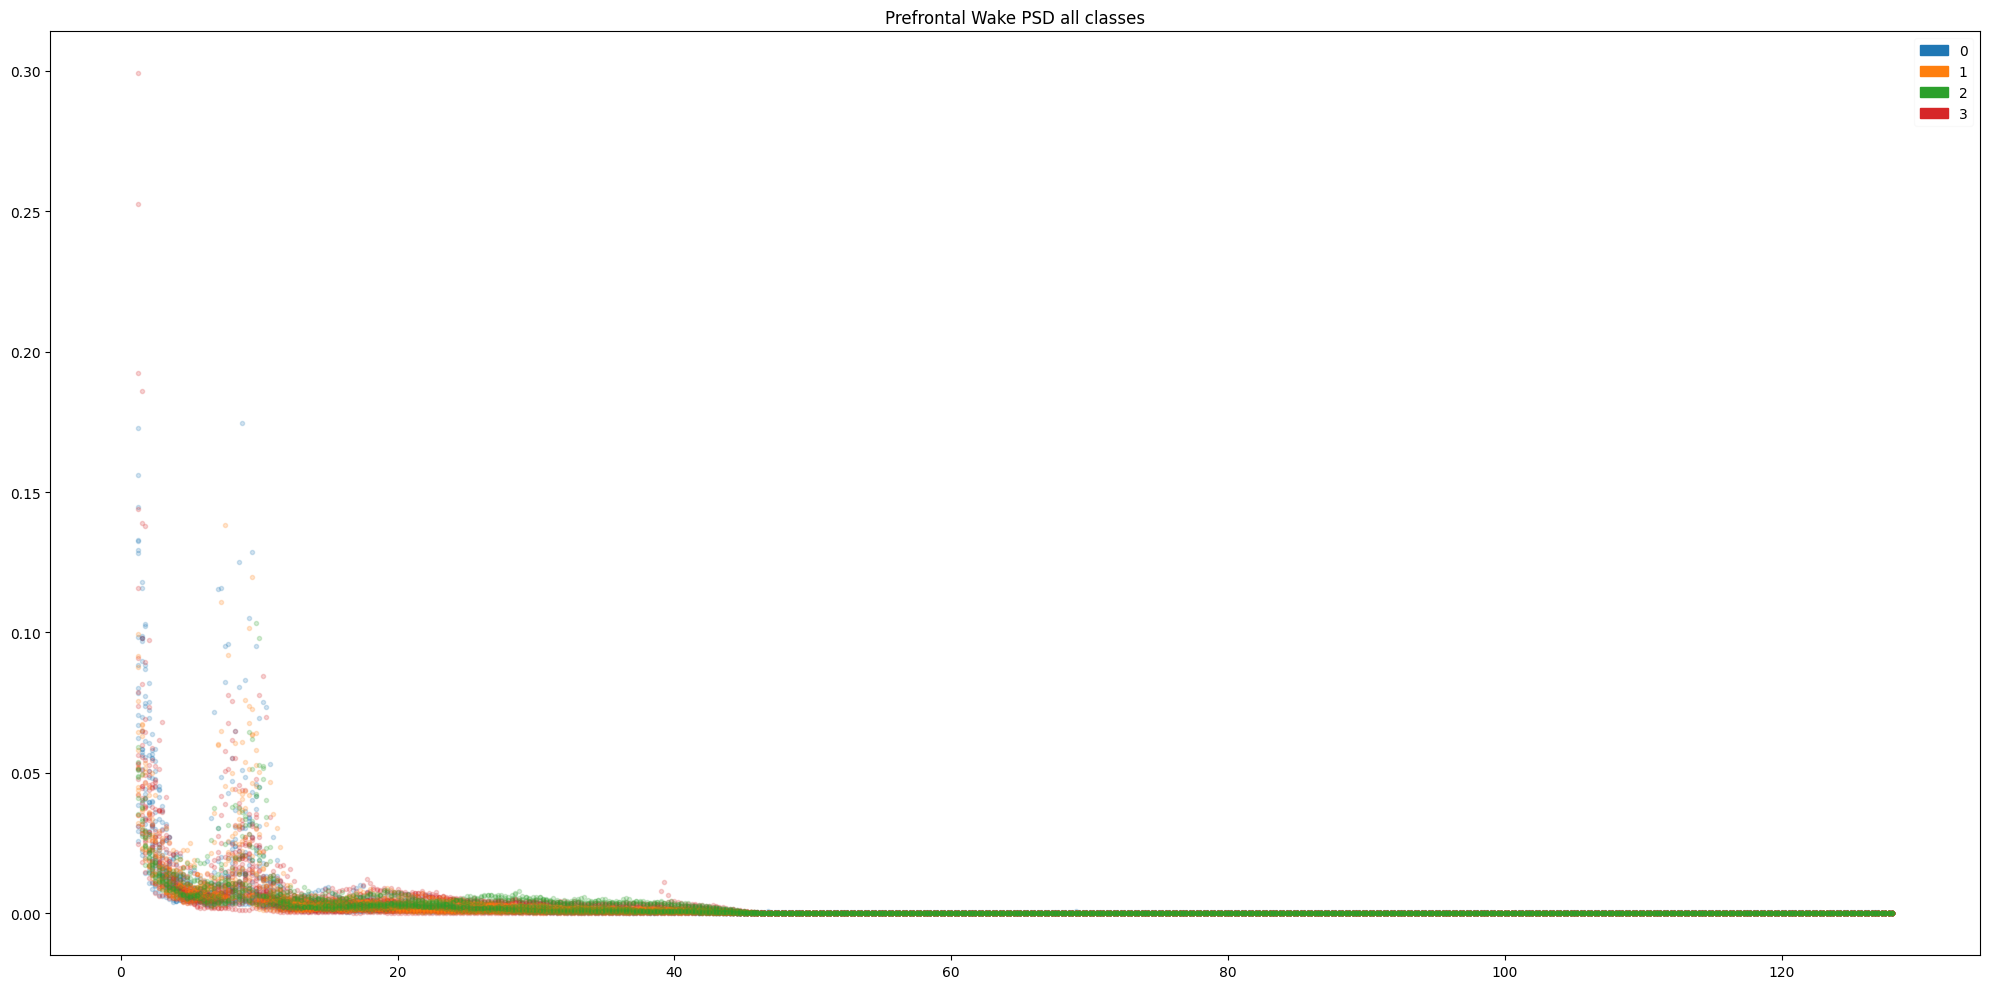

In [93]:
fig = plt.figure()
fig = plt.figure(figsize=(20,10),dpi=100)

plt.title('Prefrontal Wake PSD all classes')

for i in range(56):
    colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red'}
    plt.scatter(freqs, X_1.iloc[i,:].values , c = colors[y[i]] , label = y[i] , alpha = 0.2, marker=".")

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

plt.legend(handles=patches, framealpha = 0.1)
plt.tight_layout()
fig.savefig('Wake_Prefrontal_PSD_all_classes.png', dpi=200, bbox_inches='tight')


In [ ]:
fig = plt.figure()
fig = plt.figure(figsize=(20,10),dpi=100)

plt.title('Prefrontal Wake PSD')

for i in range(56):
    colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red'}
    plt.scatter(freqs, X_1.iloc[i,:].values , c = colors[y[i]] , label = y[i] , alpha = 0.2, marker=".")

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

plt.legend(handles=patches, framealpha = 0.1)
plt.tight_layout()